In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import seaborn as sns

In [2]:
dia_df = pd.read_csv('diabetes.csv')
dia_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


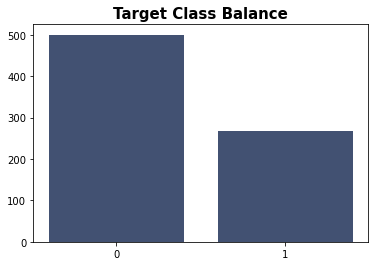

In [4]:
colors = ["#425172", '#576b99', '#78a5d1', '#eaf8fe']
class_balance = dia_df.groupby("Outcome", as_index=False)["Age"].count()
plt.bar(class_balance.iloc[:,0], class_balance.iloc[:,1], color=colors[0])
plt.xticks([0,1])
plt.title("Target Class Balance", fontsize=15, weight='bold')

plt.savefig('target_class.png', transparent=True)
plt.show()


In [5]:
missing_df = dia_df[(dia_df.Glucose == 0) | (dia_df.BloodPressure == 0) |
      (dia_df.SkinThickness == 0) | (dia_df.Insulin == 0) |
       (dia_df.BMI == 0) | (dia_df.Age == 0)]
print(f'Number of observations with missing values: {len(missing_df)}')

print(f'Number of observations without Insulin measure: {len(missing_df[missing_df.Insulin==0])}')

print(f'''
Percent of missing values in target class:
{round(len(missing_df[missing_df.Outcome==1])/len(missing_df),3)*100}
''')

Number of observations with missing values: 376
Number of observations without Insulin measure: 374

Percent of missing values in target class:
36.7



* null values are recorded as zeros in the data.
* almost all missing observations are missing insulin measurements. We may need to drop this value from our features altogether.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold,GridSearchCV 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler, OneHotEncoder, PolynomialFeatures, KBinsDiscretizer
from sklearn.impute import SimpleImputer, KNNImputer

In [7]:
X=dia_df.drop(columns=['Outcome'])
y=dia_df['Outcome']
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=36, stratify=y)

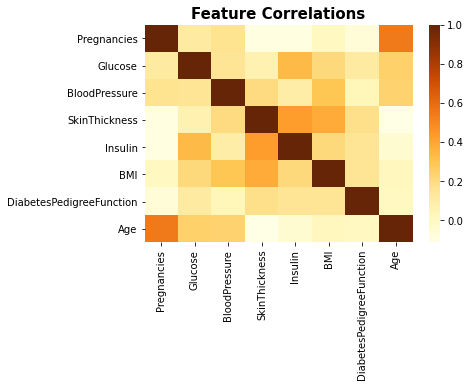

In [8]:
corr = X_tr.corr()
sns.heatmap(corr, cmap='YlOrBr')
plt.title('Feature Correlations', weight='bold', fontsize=15)
plt.savefig('feature_correlations.png', transparent=True)

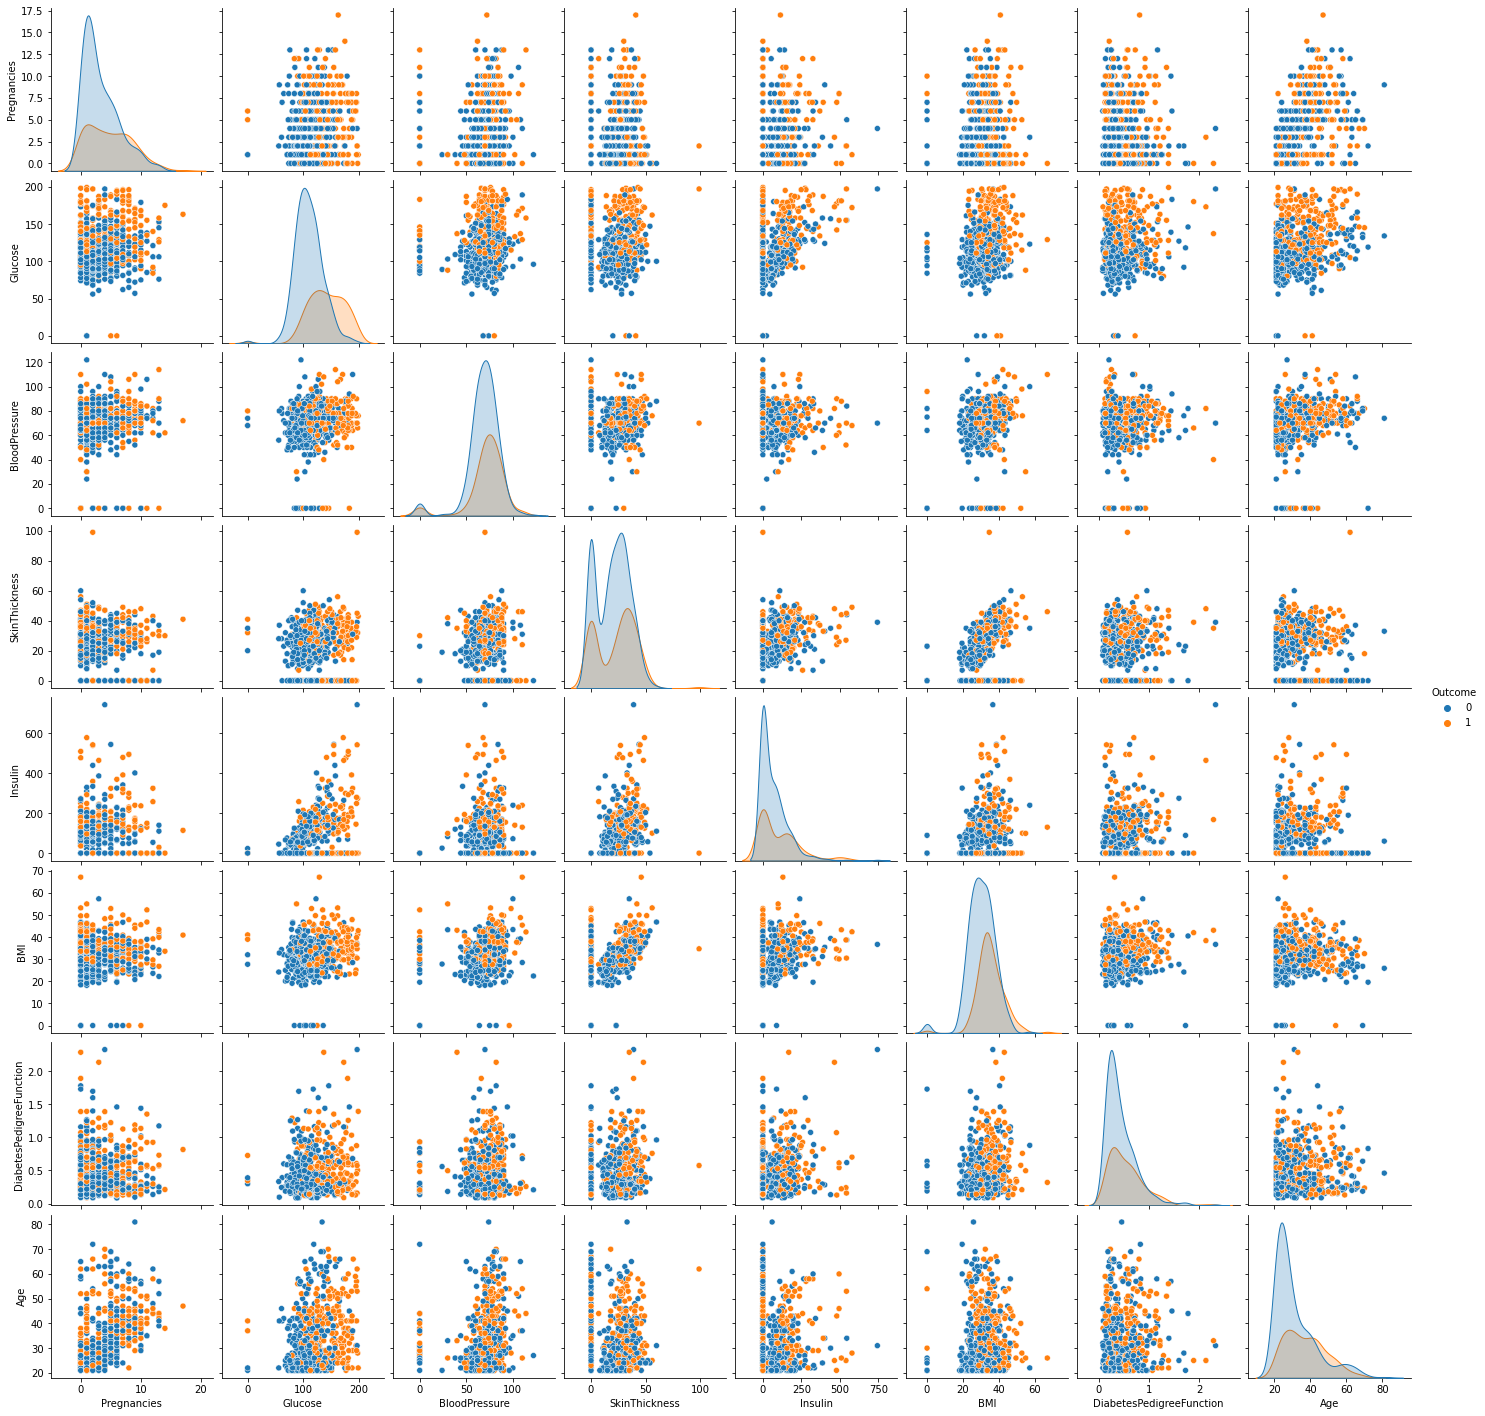

In [17]:
sns.pairplot(pd.merge(X_tr, y_tr, right_index=True, left_index = True), hue="Outcome")

* **Some features distributions appear to have separatability by the target:**
    * Glucose, Pregnancies, Age.
    * Insulin, but there are high number of missing values.
* **Some features are highly correlated with one another:**
    * Age and Pregnancy, Glucose and Insulin, Skin Thickness and BMI, in particular.
    * We may consider dropping some of these variables from our training feature matrix.

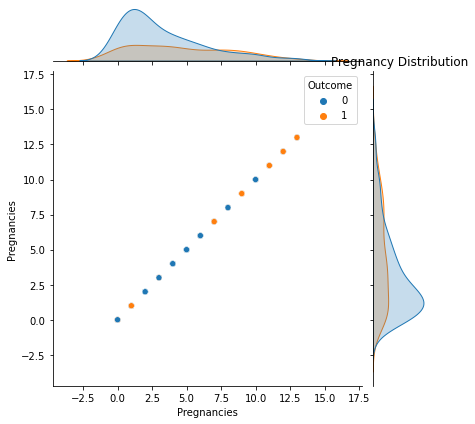

In [65]:
sns.jointplot(data=pd.merge(X_tr, y_tr, right_index=True, left_index = True),
              x='Pregnancies', y='Pregnancies', hue="Outcome")

plt.savefig('pregnancy_dist.png', transparent=True)

* seems like at 7.5 pregnanices and onward, more people are diabetic

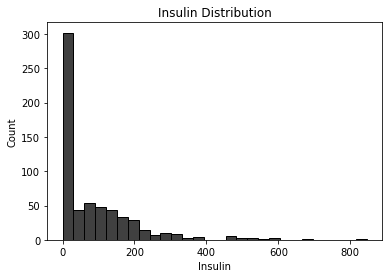

In [179]:
sns.histplot(data=pd.merge(X_tr, y_tr, right_index=True, left_index = True).Insulin, color='black')
plt.title('Insulin Distribution')
plt.savefig('insulin_dist.png', transparent=True)

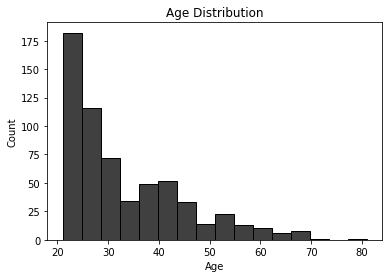

In [9]:
sns.histplot(data=pd.merge(X_tr, y_tr, right_index=True, left_index = True).Age, color='black')
plt.title('Age Distribution')
plt.savefig('age_dist.png', transparent=True)

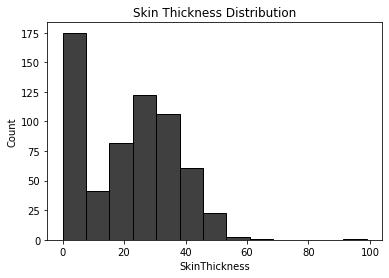

In [180]:
sns.histplot(data=pd.merge(X_tr, y_tr, right_index=True, left_index = True).SkinThickness, color='black')
plt.title('Skin Thickness Distribution')
plt.savefig('skin_thick.png', transparent=True)

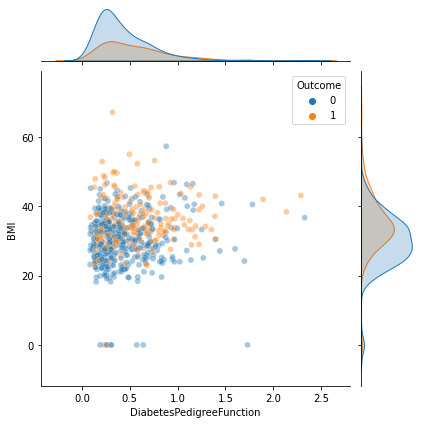

In [115]:
sns.jointplot(data=pd.merge(X_tr, y_tr, right_index=True, left_index = True),
              x='DiabetesPedigreeFunction', y='BMI', hue="Outcome", alpha= 0.4)

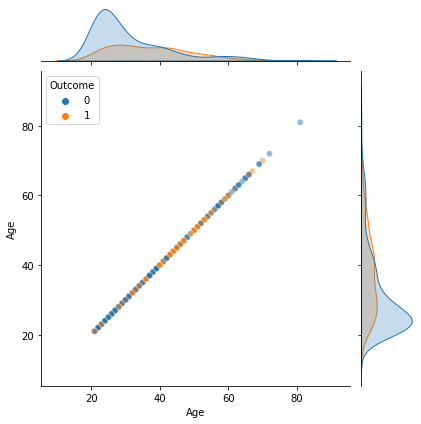

In [116]:
sns.jointplot(data=pd.merge(X_tr, y_tr, right_index=True, left_index = True),
              x='Age', y='Age', hue="Outcome", alpha=0.5)

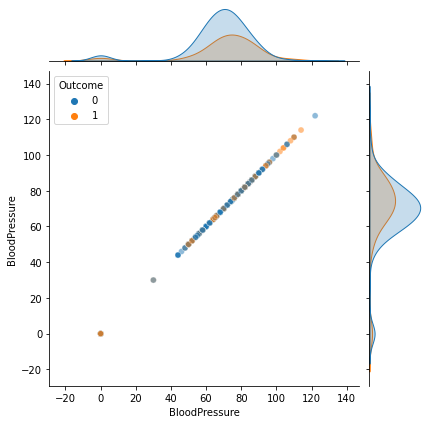

In [22]:
sns.jointplot(data=pd.merge(X_tr, y_tr, right_index=True, left_index = True),
              x='BloodPressure', y='BloodPressure', hue="Outcome", alpha=0.5)

* High diastolic blood pressure (80 or above) is proven to be directly linked to diabetes.
* The training set shows that most folks with BP of 85 or higher are diabetic.

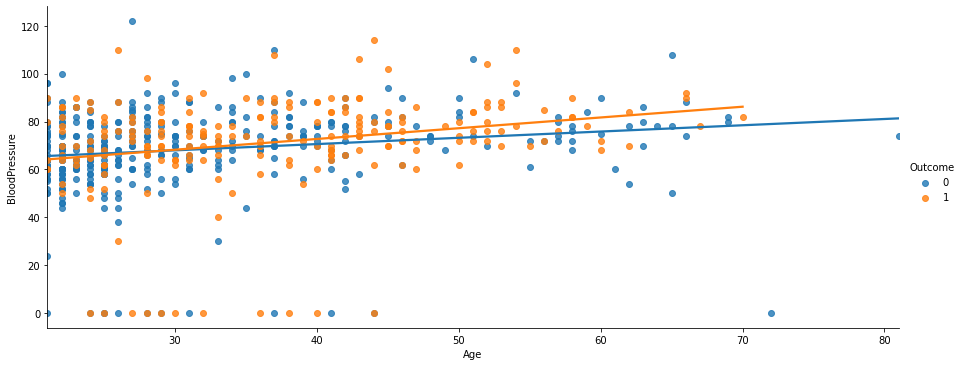

In [50]:
sns.lmplot(x='Age', 
           y='BloodPressure', 
           hue='Outcome', 
           data=pd.merge(X_tr, y_tr, right_index=True, left_index = True), 
           ci=None, 
           height=5, 
           aspect=2.5);

* most of the middle aged population is diabetic: 40-60.

In [10]:
def drop_insulin(X):
    X1=X.copy()
    X1.drop(columns=["Insulin", "SkinThickness"], inplace=True)
    return X1

def add_high_bp(X):
    X1 = X.copy()
    X1['high_bp']=np.where(X1.BloodPressure < 80, 0, 1)
    X1.drop(columns='BloodPressure', inplace=True)
    return X1
                            
def add_bmi_buckets(X):
    X1 = X.copy()
    X1['bmi_25-30'] = np.where((X1.BMI >= 25) & (X1.BMI < 30), 1, 0)
    X1['bmi_30'] = np.where(X1.BMI >= 30, 1, 0)
    X1.drop(columns='BMI', inplace=True)
    return X1
                            
def add_pregnancy(X):
    X1 = X.copy()
    X1['high_pregnancies'] = np.where(X1.Pregnancies >= 7.5, 1, 0)
    X1.drop(columns='Pregnancies', inplace=True)
    return X1
    
def add_mid_age(X):
    X1 = X.copy()
    X1['Middle_Age'] = np.where((X1.Age > 40) & (X1.Age <= 60), 1, 0)
    X1.drop(columns='Age', inplace=True)
    return X1

def get_bmi_int(X):
    X1 = X.copy()
    X1['bmi_25-30'] = np.where((X1.BMI >= 25) & (X1.BMI < 30), 1, 0)
    X1['bmi_30'] = np.where(X1.BMI >= 30, 1, 0)
    X1['func_int'] = X['DiabetesPedigreeFunction']*X1['bmi_30']
    return X1
def add_all(X):
    X1 = X.copy()
    X1['high_bp']=np.where(X1.BloodPressure < 80, 0, 1)
    X1['high_pregnancies'] = np.where(X1.Pregnancies >= 7.5, 1, 0)
    X1['bmi_25-30'] = np.where((X1.BMI >= 25) & (X1.BMI < 30), 1, 0)
    X1['bmi_30'] = np.where(X1.BMI >= 30, 1, 0)
    X1['Middle_Age'] = np.where((X1.Age > 40) & (X1.Age <= 60), 1, 0)
    X1['func_int'] = X['DiabetesPedigreeFunction']*X1['bmi_30']
    X1.drop(columns=['BloodPressure', 'BMI', 'Pregnancies', 'Age', 'SkinThickness', 'Insulin'], inplace=True)
    return X1

## Baseline Model Selection
**Which baseline model performs the best?**
    Logit, KNN, Decision Tree, Bagging Classifier, Random Forest

In [14]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score, make_scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

lm = LogisticRegression(random_state=36)
knn = KNeighborsClassifier(n_neighbors=10)

rf = RandomForestClassifier(random_state=36)
bg = BaggingClassifier(random_state=36)
dt = DecisionTreeClassifier(random_state=36)

scaler=StandardScaler()

std_models = [lm, knn]
unstd_models = [dt, rf, bg]
cv =  RepeatedStratifiedKFold(n_splits=10, random_state=36)


X1 = X_tr.copy()
var_list= ['Glucose', 'BloodPressure',
           'SkinThickness', 'Insulin', 'BMI', 'Age']
for i in var_list:
    X1[i]= np.where(X1[i]==0, np.mean(X1[i]), X1[i])

baseline_results_dict = {'model': [], 'recall': [], 'f2': []}

for i in unstd_models:
    baseline_results_dict['model'].append(str(i))
   
    baseline_results_dict['recall'].append(np.mean(cross_val_score(i, X1,
                              y_tr, cv=cv, scoring ='recall')))
    baseline_results_dict['f2'].append(np.mean(cross_val_score(i, X1,
                              y_tr, cv=cv, scoring = f2_scorer)))


scaler.fit_transform(X1)


for i in std_models:
    baseline_results_dict['model'].append(str(i))
   
    baseline_results_dict['recall'].append(np.mean(cross_val_score(i, X1,
                              y_tr, cv=cv, scoring ='recall')))
    baseline_results_dict['f2'].append(np.mean(cross_val_score(i, X1,
                              y_tr, cv=cv, scoring = f2_scorer)))




/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

,model,recall,f2
0,DecisionTreeClassifier(random_state=36),0.570325,0.568984
1,RandomForestClassifier(random_state=36),0.598030,0.611605
2,BaggingClassifier(random_state=36),0.550130,0.569244
3,LogisticRegression(random_state=36),0.588290,0.607668
4,KNeighborsClassifier(n_neighbors=10),0.506970,0.533704


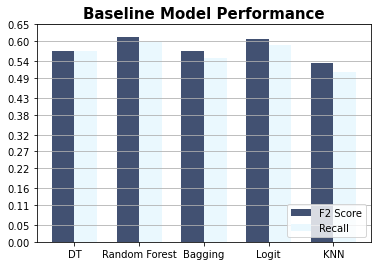

In [29]:
baseline_result=pd.DataFrame(baseline_results_dict)
baseline_result["model_name"]=["DT", "Random Forest", "Bagging", "Logit", 'KNN']
baseline_result.drop(columns='model', inplace=True)
x = np.arange(len(baseline_result["model_name"]))  # the label locations
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(x- width/2, baseline_result['f2'], width, label='F2',color=colors[0])
rects2 = ax.bar(x + width/2, baseline_result['recall'], width, label='Recall', color = colors[3])

plt.grid(axis='y')

plt.xticks(x, baseline_result['model_name'])
plt.yticks([round(i, 2) for i in np.linspace(0, 0.65, 13)])
plt.legend(['F2 Score', 'Recall'], loc=4)
plt.title('Baseline Model Performance', weight='bold', fontsize=15)
plt.savefig('Baseline_Model_Performance.png', transparent=True)
plt.show()


In [31]:
baseline_result

,recall,f2,model_name
0,0.570325,0.568984,DT
1,0.598030,0.611605,Random Forest
2,0.550130,0.569244,Bagging
3,0.588290,0.607668,Logit
4,0.506970,0.533704,KNN


In [147]:
pd.DataFrame(results_dict)

,model,recall,f2
0,none,0.581041,0.606258
1,bp,0.573566,0.600265
2,bmi,0.566877,0.592328
3,pregnancies,0.583311,0.606278
4,mid-age,0.588959,0.614027
5,add_interact,0.572558,0.596729
6,all,0.598239,0.621522


* Adding Features

In [32]:
ft_results_lr_dict = {'model': ['base'], 'recall': [0.588290], 'f2': [0.607668]}
X_c1 = X_tr.copy()
scaler=StandardScaler()
impute = SimpleImputer(strategy='mean', missing_values=0)
cv= RepeatedStratifiedKFold(n_splits=5, random_state=36)
lr = LogisticRegression(random_state=36)
rf = RandomForestClassifier(random_state=36)

feature_eng = [('drop insulin & skin thickness', drop_insulin(X_c1)), ('bp', add_high_bp(X_c1)),
           ('bmi', add_bmi_buckets(X_c1)), ('pregnancies', add_pregnancy(X_c1)),
           ('mid-age', add_mid_age(X_c1)), ('add_interact', get_bmi_int(X_c1)),
           ('all', add_all(X_c1))]
for i in feature_eng:
    data = impute.fit_transform(i[1])
    data = scaler.fit_transform(data)
    ft_results_lr_dict['model'].append(i[0])
   
    ft_results_lr_dict['recall'].append(np.mean(cross_val_score(lr, data,
                              y_tr, cv=cv, scoring ='recall')))
    ft_results_lr_dict['f2'].append(np.mean(cross_val_score(lr, data,
                              y_tr, cv=cv, scoring = f2_scorer)))


ft_eng_lr = pd.DataFrame(ft_results_lr_dict)


In [35]:
ft_results_rf_dict = {'model': ['base'], 'recall': [0.598030], 'f2': [0.611605]}
X_c2 = X.copy()
scaler=StandardScaler()
impute = SimpleImputer(strategy='mean', missing_values=0)
cv= RepeatedStratifiedKFold(n_splits=5, random_state=36)
rf = RandomForestClassifier(random_state=36)

feature_eng = [('drop insulin & skin thickness', drop_insulin(X_c2)), ('bp', add_high_bp(X_c2)),
           ('bmi', add_bmi_buckets(X_c2)), ('pregnancies', add_pregnancy(X_c2)),
           ('mid-age', add_mid_age(X_c2)), ('add_interact', get_bmi_int(X_c2)),
           ('all', add_all(X_c2))]
for i in feature_eng:
    data = impute.fit_transform(i[1])
    data = scaler.fit_transform(data)
    ft_results_rf_dict['model'].append(i[0])
   
    ft_results_rf_dict['recall'].append(np.mean(cross_val_score(rf, data,
                              y, cv=cv, scoring ='recall')))
    ft_results_rf_dict['f2'].append(np.mean(cross_val_score(rf, data,
                              y, cv=cv, scoring = f2_scorer)))


ft_eng_rf = pd.DataFrame(ft_results_rf_dict)

In [38]:
ft_eng_lr.sort_values('recall', ascending= False)

,model,recall,f2
4,pregnancies,0.588771,0.608494
0,base,0.588290,0.607668
6,add_interact,0.586844,0.607628
1,drop insulin & skin thickness,0.585426,0.607319
5,mid-age,0.585050,0.607419
2,bp,0.578439,0.600162
3,bmi,0.564850,0.584955
7,all,0.528162,0.555438


In [39]:
ft_eng_rf.sort_values('recall', ascending= False)

,model,recall,f2
1,drop insulin & skin thickness,0.598672,0.612917
0,base,0.598030,0.611605
4,pregnancies,0.595024,0.608768
6,add_interact,0.589378,0.604938
2,bp,0.583110,0.597743
3,bmi,0.559867,0.575058
5,mid-age,0.553578,0.569723
7,all,0.543515,0.555799


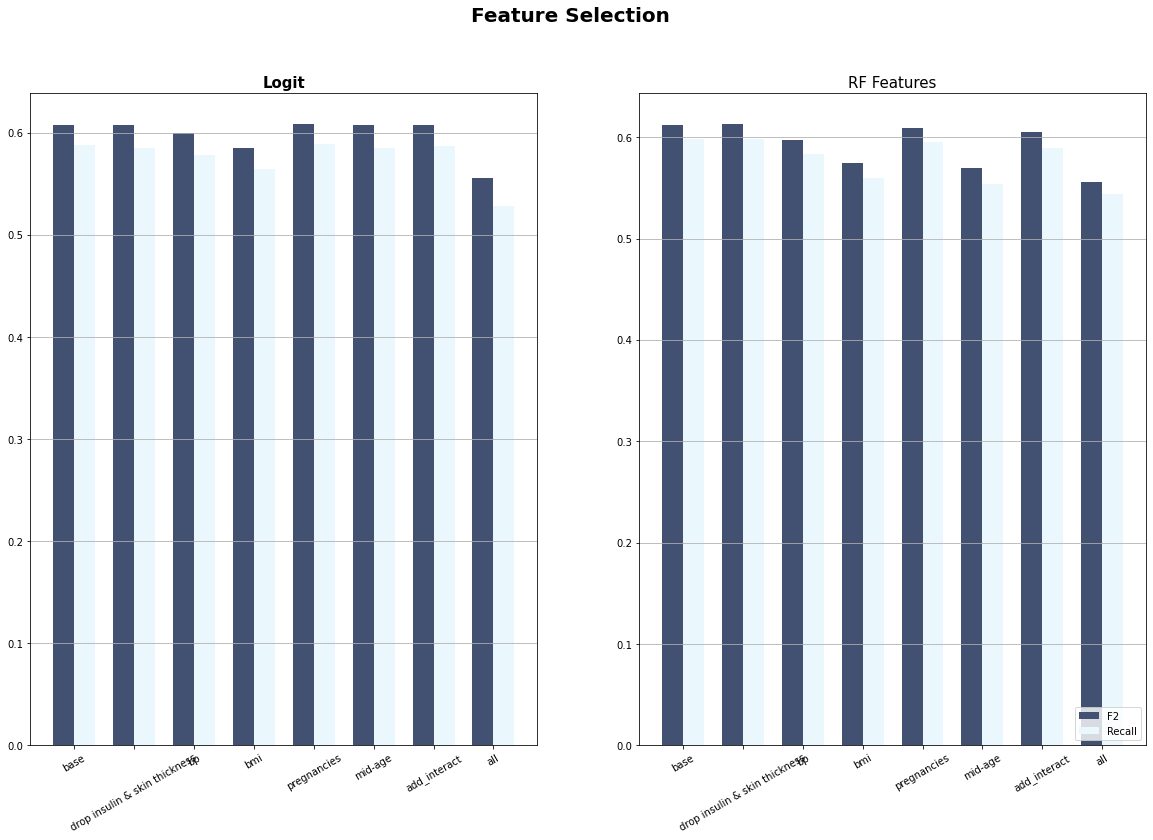

In [63]:
x = np.arange(len(ft_eng_lr["model"]))  # the label locations
width = 0.35 

plt.rcParams["figure.figsize"] = (20, 12)
fig, (ax1,  ax2)= plt.subplots(1, 2)

fig.suptitle("Feature Selection", fontsize=20, weight='bold')
ax1.bar(x- width/2, ft_eng_lr['f2'], width, label='F2',color=colors[0])
ax1.bar(x + width/2, ft_eng_lr['recall'], width, label='Recall', color = colors[3])

ax1.grid(axis='y')

ax1.set_xticks(x)
ax1.set_xticklabels(ft_eng_lr['model'], rotation=30)
ax1.set_title('Logit', weight='bold', fontsize=15)


x = np.arange(len(ft_eng_rf["model"]))  # the label locations

ax2.bar(x- width/2, ft_eng_rf['f2'], width, label='F2',color=colors[0])
ax2.bar(x + width/2, ft_eng_rf['recall'], width, label='Recall', color = colors[3])

ax2.grid(axis='y')

ax2.set_xticks(x)
ax2.set_xticklabels(ft_eng_rf['model'], rotation=30)
ax2.set_title('RF Features',  fontsize=15)
plt.legend(['F2', 'Recall'],loc=4)
plt.savefig('Features.png', transparent=True)
plt.show()


In [66]:
grid_rf = {'max_depth':[i for i in np.arange(3, 30)],
           'max_features':['auto', 'sqrt'],
           'n_estimators':[i for i in np.arange(100, 1010, 10)],
           'min_samples_split' : [2, 5, 10],
           'min_samples_leaf' : [1, 2, 3, 4, 5]
          }
rf = RandomForestClassifier(random_state = 36)
from sklearn.model_selection import RandomizedSearchCV
random_rf = RandomizedSearchCV(rf, param_distributions=grid_rf, n_jobs=-1,
                               cv=5, scoring=f2_scorer)
X_eng = drop_insulin(X.copy())
data = impute.fit_transform(X_eng)
random_rf.fit(data, y)
random_rf.best_params_



{'n_estimators': 630,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 21}

In [67]:
rf_opt = RandomForestClassifier(random_state=36, n_estimators= 630,
                            min_samples_split=10, min_samples_leaf= 1,
                            max_features='sqrt', max_depth=21)
rf_opt.fit(data, y)
print(f'recall score: {round(recall_score(y, rf_opt.predict(data)), 3)}')
print(f'f2 score: {round(fbeta_score(y, rf_opt.predict(data), beta=2),3)}')
print(f'confustion_matrix:\n {confusion_matrix(y, rf_opt.predict(data))}')

recall score: 0.892
f2 score: 0.903
confustion_matrix:
 [[487  13]
 [ 29 239]]


In [153]:
grid_rf = {'max_depth':[i for i in np.arange(3, 30)],
           'max_features':['auto', 'sqrt'],
           'n_estimators':[i for i in np.arange(100, 1010, 10)],
           'min_samples_split' : [2, 5, 10],
           'min_samples_leaf' : [1, 2, 3, 4, 5]
          }
rf = RandomForestClassifier(random_state = 36)
from sklearn.model_selection import RandomizedSearchCV
random_rf = RandomizedSearchCV(rf, param_distributions=grid_rf, n_jobs=-1,
                               cv=5, scoring=f2_scorer)
X_eng = drop_insulin(X.copy())
X_eng.drop(columns=['DiabetesPedigreeFunction'], inplace=True)
data = impute.fit_transform(X_eng)
random_rf.fit(data, y)
random_rf.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 6}

In [71]:
grid_rf = {'max_depth':[i for i in np.arange(3, 30)],
           'max_features':['auto', 'sqrt'],
           'n_estimators':[i for i in np.arange(100, 1010, 10)],
           'min_samples_split' : [2, 5, 10],
           'min_samples_leaf' : [1, 2, 3, 4, 5]
          }
rf = RandomForestClassifier(random_state = 36)
from sklearn.model_selection import RandomizedSearchCV
random_rf = RandomizedSearchCV(rf, param_distributions=grid_rf, n_jobs=-1,
                               cv=5, scoring=f2_scorer)
X_eng = drop_insulin(X.copy())
X_eng = add_pregnancy(X_eng)
data1 = impute.fit_transform(X_eng)
random_rf.fit(data1, y)
random_rf.best_params_


{'n_estimators': 260,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 13}

In [72]:
rf_2 = RandomForestClassifier(random_state=36, n_estimators= 260,
                            min_samples_split=5, min_samples_leaf= 1,
                            max_features='auto', max_depth=13)
rf_2.fit(data1, y)
print(f'recall score: {round(recall_score(y, rf_2.predict(data1)), 3)}')
print(f'f2 score: {round(fbeta_score(y, rf_2.predict(data1), beta=2),3)}')
print(f'confustion_matrix:\n {confusion_matrix(y, rf_2.predict(data1))}')

recall score: 0.951
f2 score: 0.958
confustion_matrix:
 [[496   4]
 [ 13 255]]


In [154]:
rf_opt = RandomForestClassifier(random_state=36, n_estimators= 300,
                            min_samples_split=2, min_samples_leaf= 2,
                            max_features='auto', max_depth=6)
rf_opt.fit(data, y)
print(f'recall score: {round(recall_score(y, rf_opt.predict(data)), 3)}')
print(f'f2 score: {round(fbeta_score(y, rf_opt.predict(data), beta=2),3)}')

recall score: 0.772
f2 score: 0.782


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [228]:
from sklearn.ensemble import RandomForestClassifier
X_rf_eng = drop_insulin(X.copy())
X_rf_eng = impute.fit_transform(X_rf_eng)
rf_opt = RandomForestClassifier(random_state=36, n_estimators= 520,
                            min_samples_split=10, min_samples_leaf= 1,
                            max_features='sqrt', max_depth=19)
from sklearn.metrics import confusion_matrix
rf_opt.fit(X_rf_eng, y)
confusion_matrix(y, rf_opt.predict(X_rf_eng))

array([[486,  14],
       [ 29, 239]])

In [75]:
import joblib
joblib.dump(rf_opt, 'rf_clf.pkl')

['rf_clf.pkl']

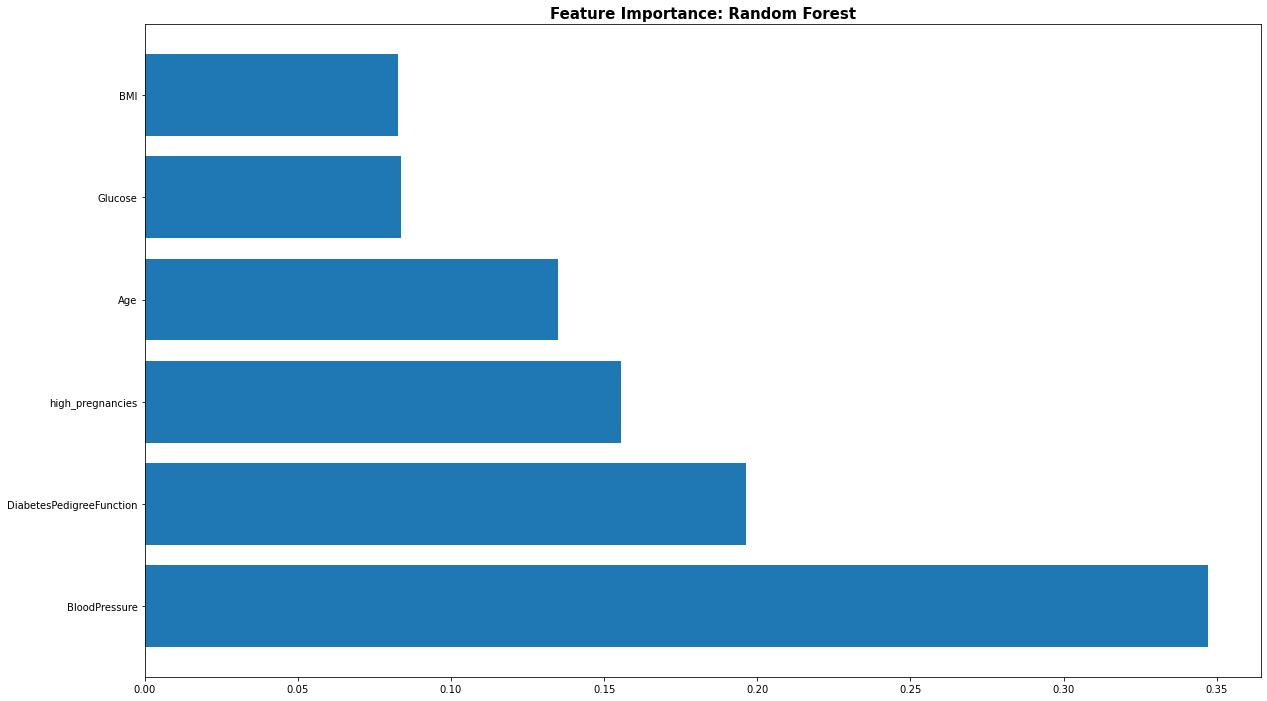

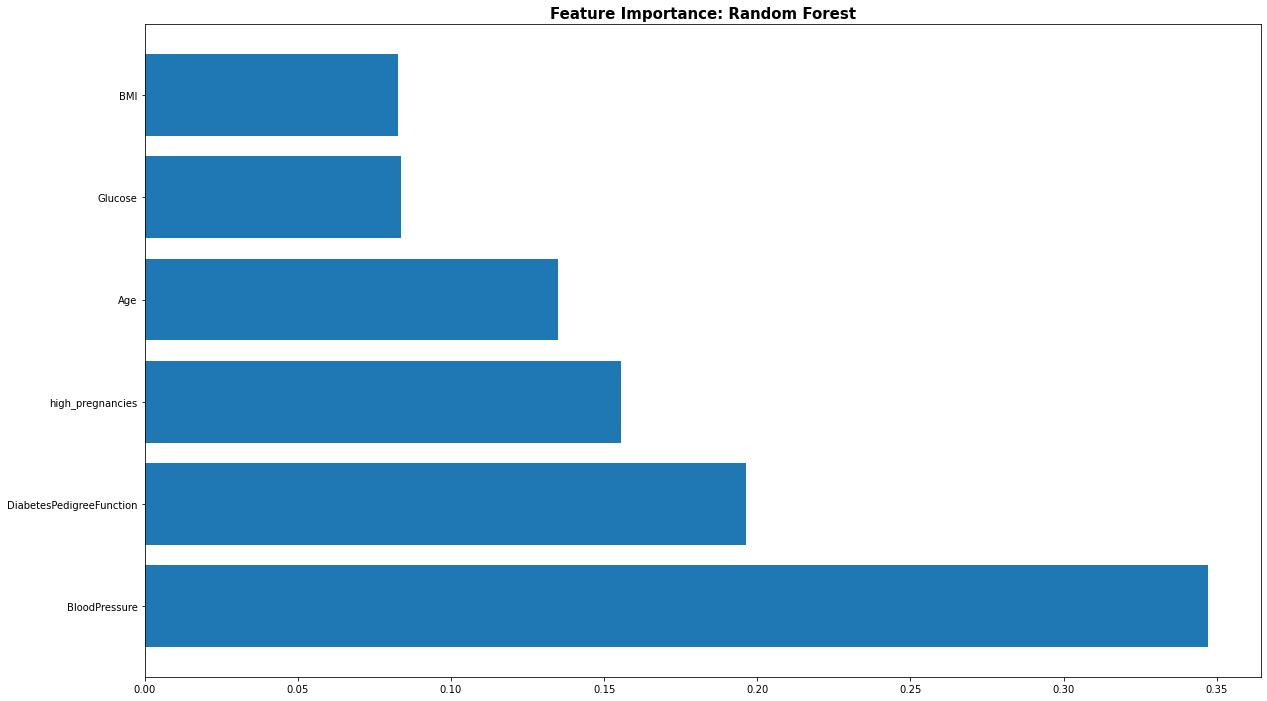

In [74]:
rf_ft = [i for i in rf_opt.feature_importances_]
col_names = [b for b in X_eng.columns.to_list()]
ft_dicts = []
for i, s in (zip(col_names, rf_ft)):
    dict_row = {}
    dict_row['feature']=i
    dict_row['importance'] = s
    ft_dicts.append(dict_row)
rf_features = pd.DataFrame(ft_dicts).sort_values('importance', ascending=False)
plt.barh(rf_features['feature'],rf_features['importance'])
plt.title("Feature Importance: Random Forest", fontsize=15, weight='bold')
plt.savefig('ft.importance.png', transparent=True)
plt.show('')

Text(0.5, 1.0, 'Precision and Recall Curves: Decision Tree')

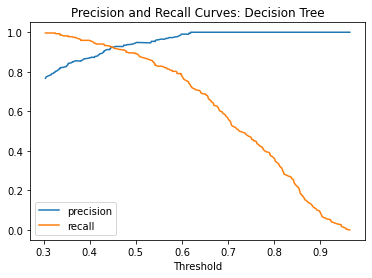

In [94]:
from sklearn.metrics import precision_recall_curve
precision_curve, recall_curve, threshold_curve= precision_recall_curve(y, rf_opt.predict_proba(data)[:,1])
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend()
plt.xlabel("Threshold")
plt.title('Precision and Recall Curves: Decision Tree')
plt.show()

In [76]:
lm = LogisticRegression(random_state=36)
c_range = np.arange(0.01, 1, 0.01)
param_grid_lm = {'C': c_range,
                 'class_weight': ['none','balanced'],
                 'penalty': ['l1', 'l2', 'none', 'elasticnet'],
                 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
cv= RepeatedStratifiedKFold(n_splits=5, random_state=36)
random_lm = RandomizedSearchCV(lm, param_distributions=param_grid_lm, n_jobs=-1,
                               cv=cv, scoring=f2_scorer)
X_eng = drop_insulin(X_tr.copy())
X_eng = add_pregnancy(X_eng)
data = impute.fit_transform(X_eng)
data = scaler.fit_transform(data)
random_lm.fit(data, y_tr)
random_lm.best_params_


/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.60620289 0.72936845 0.71038911        nan        nan 0.71130931
 0.60473473 0.60620289 0.70911745        nan]
  warnings.warn(


{'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced', 'C': 0.08}

In [83]:

lm_opt = LogisticRegression(random_state=36, solver='liblinear', penalty='l1', class_weight='balanced', C=0.08)

recall_lm = np.mean(cross_val_score(lm_opt, data, y_tr, cv=cv, scoring ='recall'))
f2_lm = np.mean(cross_val_score(lm_opt, data, y_tr, cv=cv, scoring =f2_scorer))
lm_opt.fit(data, y_tr)
print(f'recall score: {round(recall_lm, 3)}')
print(f'f2l score: {round(f2_lm, 3)}')
print(f'confusion matrix:\n {confusion_matrix(y_tr, lm_opt.predict(data))}')

In [94]:
print(f'recall score: {round(recall_lm, 3)}')
print(f'f2l score: {round(f2_lm, 3)}')
print(f'confusion matrix:\n {confusion_matrix(y_tr, lm_opt.predict(data))}')

recall score: 0.767
f2l score: 0.729
confusion matrix:
 [[305  95]
 [ 51 163]]


In [92]:
y_te

160    0
613    0
552    0
88     1
284    1
      ..
634    0
50     0
211    0
78     1
40     0
Name: Outcome, Length: 154, dtype: int64

In [93]:
X_te_eng = drop_insulin(X_te.copy())
X_te_eng = add_pregnancy(X_te_eng)
data_lm = impute.fit_transform(X_te_eng)
data_lm = scaler.fit_transform(data_lm)

print(f'recall score: {round(recall_score(y_te, lm_opt.predict(data_lm)), 3)}')
print(f'f2 score: {round(fbeta_score(y_te, lm_opt.predict(data_lm), beta=2),3)}')
print(f'confustion matrix: \n {confusion_matrix(y_te, lm_opt.predict(data_lm))}')

recall score: 0.63
f2 score: 0.62
confustion matrix: 
 [[76 24]
 [20 34]]


In [197]:
from sklearn.metrics import roc_curve

#random forest Randomized Grid Search CV optimized
X_eng = drop_insulin(X.copy())
data_rf = impute.fit_transform(X_eng)
fpr3, tpr3, thresholds3 = roc_curve(y, rf_opt.predict_proba(data_rf)[:,1])
#lm
X_eng = drop_insulin(X_te.copy())
data = impute.fit_transform(X_eng)
data_lm = scaler.fit_transform(data)

fpr4, tpr4, thresholds4 = roc_curve(y_te, lm_opt.predict_proba(data_lm)[:,1])
plt.figure()
#xgboost


plt.plot(fpr3, tpr3)
plt.plot(fpr4, tpr4)
plt.plot([0,1],[0,1],c='g',ls='--')
plt.plot;

clf_str = 'CLF n=590, F2: {}'.format(round(fbeta_score(y, rf_opt.predict(data_rf), beta=2),3))
logit_str = 'Logit, c=0.05, F2: {}'.format(round(fbeta_score(y_tr, lm_opt.predict(data_lm), beta=2),3))

plt.title("ROC Curves: Tuned Logit and CLF")
plt.legend([clf_str, logit_str] )
plt.xlabel("FPR")
plt.ylabel("TPR")

plt.show();


ValueError: X has 6 features, but DecisionTreeClassifier is expecting 5 features as input.

In [90]:
X.te

AttributeError: 'DataFrame' object has no attribute 'te'

In [179]:
lm_eng = LogisticRegression(random_state=36)
rf_eng = RandomForestClassifier(random_state=36)

std_models_eng = [lm_eng]
unstd_models = [rf_eng]

X1 = X_tr.copy()

#dropping insulin and skin thickness
X1.drop(columns=['SkinThickness', 'Insulin'], inplace=True)

#imputing means
var_list= ['Glucose', 'BloodPressure', 'BMI', 'Age']
for i in var_list:
    X1[i]= np.where(X1[i]==0, np.mean(X1[i]), X1[i])
X1=add_all(X1)


for i in unstd_models:
    baseline_results_dict['model'].append(str(i)+"_eng")
   
    baseline_results_dict['recall'].append(np.mean(cross_val_score(i, X1,
                              y_tr, cv=cv, scoring ='recall')))
    baseline_results_dict['f2'].append(np.mean(cross_val_score(i, X1,
                              y_tr, cv=cv, scoring = f2_scorer)))


scaler.fit_transform(X1)


for i in std_models:
    baseline_results_dict['model'].append(str(i)+"_eng")
   
    baseline_results_dict['recall'].append(np.mean(cross_val_score(i, X1,
                              y_tr, cv=cv, scoring ='recall')))
    baseline_results_dict['f2'].append(np.mean(cross_val_score(i, X1,
                              y_tr, cv=cv, scoring = f2_scorer)))



/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

*Random Forest It is!

In [110]:
import xgboost as xgb
from xgboost import cv
from xgboost import XGBClassifier
from xgboost import DMatrix 
X_tr_xg = X_tr.copy()
X_te_xg = X_te.copy()
X_tr_xg = drop_insulin(X_tr_xg)

data_dmatrix = xgb.DMatrix(data=X_tr_xg,label=y_tr)

params = {'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=50,
            early_stopping_rounds=10, metrics='auc', as_pandas=True, seed=3) 

xgb_cv.mean()

[09:54:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:54:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:54:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86

AttributeError: 'DataFrame' object has no attribute 'fit'

In [131]:
from xgboost import sklearn
from sklearn.model_selection import RandomizedSearchCV

param_grid= {'max_depth': [3, 4,5,6,7,8],
            'gamma': np.linspace(0.1, 0.95, 18),
            'learning_rate': np.linspace(0.1, 0.5, 5),
            'colsample_bytree':np.linspace(0.1, 0.95, 18)}

xgb_clf = XGBClassifier(objective='binary:logistic', seed=3)

cv= RepeatedStratifiedKFold(n_splits=5, random_state=36)

xgb_cv = RandomizedSearchCV(xgb_clf, param_distributions=param_grid, n_jobs=-1,
                               cv=cv, scoring=f2_scorer)

xgb_cv.fit(X_tr_xg, y_tr)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=36),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=Non...
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
           

In [136]:
xgb_cv.best_params_

params_opt= {'objective':'binary:logistic',
             'max_depth': 5,
            'gamma': 0.30000000000000004,
            'learning_rate': 0.7999999999999999,
            'colsample_bytree':0.8999999999999999}
from xgboost import cv
xgb_opt_cv = cv(dtrain=data_dmatrix, params=params_opt, nfold=3, num_boost_round=50,
            early_stopping_rounds=10, metrics='auc', as_pandas=True, seed=3) 

xgb_opt_cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.909084,0.006165,0.790489,0.012055
1,0.945900,0.004492,0.808381,0.018495
2,0.956104,0.007329,0.819474,0.018326
3,0.971366,0.008384,0.823378,0.015785
4,0.981637,0.004293,0.826275,0.009378
5,0.986736,0.002267,0.828819,0.009048


In [137]:
xgb_opt_cv.mean()

train-auc-mean    0.958471
train-auc-std     0.005489
test-auc-mean     0.816136
test-auc-std      0.013848
dtype: float64

In [141]:
from sklearn.metrics import roc_auc_score
print(f'Tuned Random Forest AUC: {roc_auc_score(y, rf_opt.predict_proba(data_rf)[:,1])}')
print(f'Tuned Logit AUC: {roc_auc_score(y_tr, lm_opt.predict_proba(data_lm)[:,1])}')


Tuned Random Forest AUC: 0.9900522388059702
Tuned Logit AUC: 0.8497546728971963


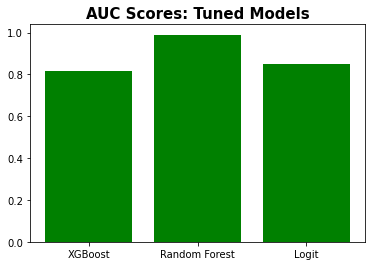

In [145]:
auc_models_dict = {'model': ['XGBoost', 'Random Forest', 'Logit'],
                   'auc score': [xgb_opt_cv['test-auc-mean'].mean(),
                                (roc_auc_score(y, rf_opt.predict_proba(data_rf)[:,1])),
                                (roc_auc_score(y_tr, lm_opt.predict_proba(data_lm)[:,1]))]}
auc = pd.DataFrame(auc_models_dict) 

plt.bar(auc['model'], auc['auc score'], color='g')
plt.title('AUC Scores: Tuned Models', fontsize=15, weight='bold')
plt.show()